# Left vs Right #
This dataset is made up of tweets that link to news outlets that are seen as having a left wing or right wing bias. Foxnews (moderate) and Breitbart (extreme) on the right, labelled 0, and MSNBC (moderate) and Slate and The NewYorker (extreme) on the left, labelled 1. The set contains about 30,000 tweets.

Import libraries and load dataset

In [1]:
import tensorflow as tf
from tensorflow import keras
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

DATASET = 'left_vs_right'

tf.compat.v1.enable_eager_execution()
tf.keras.backend.clear_session()

In [2]:
with open('..\\dataset_creation\\datasets\\'+DATASET+'\\tweets.txt', encoding="utf8") as f:
    raw_tweets = f.readlines()

with open('..\\dataset_creation\\datasets\\'+DATASET+'\\labels.txt')as f:
    raw_labels = f.readlines()

target_dataset = list()
for label in raw_labels:
    if label == '1\n':
        target_dataset.append(1)
    else:
        target_dataset.append(0)

SPLIT = round(len(raw_tweets)*0.1)

Split test set and preprocess data

In [3]:
def preprocess(X_batch, y_batch):
    X_batch = tf.strings.substr(X_batch, 0, 240)
    X_batch = tf.strings.regex_replace(X_batch, b"<br\\s*/?>", b" ")
    X_batch = tf.strings.regex_replace(X_batch, b"[^a-zA-Z']", b" ")
    X_batch = tf.strings.split(X_batch)
    y_batch = tf.convert_to_tensor(y_batch, dtype=tf.int64)
    return X_batch.to_tensor(default_value=b"<pad>"), y_batch

In [4]:
X_batch, y_batch = preprocess(raw_tweets, target_dataset)

In [5]:
X_test, X_train_full = X_batch[:SPLIT], X_batch[SPLIT:]
y_test, y_train_full = y_batch[:SPLIT], y_batch[SPLIT:]

Create vocabulary lookup table

In [6]:
vocabulary = Counter()
for tweet in X_train_full:
    vocabulary.update(list(tweet.numpy()))

In [7]:
vocab_size = 10000
truncated_vocabulary = [
    word for word, count in vocabulary.most_common()[:vocab_size]
]

In [8]:
words = tf.constant(truncated_vocabulary)
word_ids = tf.range(len(truncated_vocabulary), dtype=tf.int64)
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)
num_oov_buckets = 1000
table = tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets)

Split validation set and encode words with look up table

In [9]:
def encode_words(dataset_input):
    return table.lookup(dataset_input)

In [10]:
X_valid, X_train = encode_words(X_train_full[:SPLIT]), encode_words(X_train_full[SPLIT:])
y_valid, y_train = y_train_full[:SPLIT], y_train_full[SPLIT:]

Define, compile and run model

In [11]:
embed_size = 8
model7 = keras.models.Sequential([
    keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size, mask_zero=True),
    keras.layers.GRU(embed_size, dropout=0.5, activation="sigmoid", return_sequences=True),
    keras.layers.GRU(embed_size, dropout=0.5, activation="sigmoid"),
    keras.layers.Dense(1, activation="sigmoid")
])

In [12]:
model7.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [13]:
model7.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 8)           88000     
_________________________________________________________________
gru (GRU)                    (None, None, 8)           432       
_________________________________________________________________
gru_1 (GRU)                  (None, 8)                 432       
_________________________________________________________________
dense (Dense)                (None, 1)                 9         
Total params: 88,873
Trainable params: 88,873
Non-trainable params: 0
_________________________________________________________________


In [14]:
history7 = model7.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_valid, y_valid))

Train on 23718 samples, validate on 2965 samples
Epoch 1/10
23718/23718 [==============================] - 74s 3ms/sample - loss: 0.6905 - accuracy: 0.5328 - val_loss: 0.6706 - val_accuracy: 0.6159
Epoch 2/10
23718/23718 [==============================] - 78s 3ms/sample - loss: 0.5505 - accuracy: 0.7360 - val_loss: 0.3955 - val_accuracy: 0.8449
Epoch 3/10
23718/23718 [==============================] - 97s 4ms/sample - loss: 0.3936 - accuracy: 0.8267 - val_loss: 0.3535 - val_accuracy: 0.8560
Epoch 4/10
23718/23718 [==============================] - 143s 6ms/sample - loss: 0.3469 - accuracy: 0.8432 - val_loss: 0.3386 - val_accuracy: 0.8644
Epoch 5/10
23718/23718 [==============================] - 177s 7ms/sample - loss: 0.3193 - accuracy: 0.8541 - val_loss: 0.3334 - val_accuracy: 0.8698
Epoch 6/10
23718/23718 [==============================] - 210s 9ms/sample - loss: 0.2984 - accuracy: 0.8615 - val_loss: 0.3345 - val_accuracy: 0.8745
Epoch 7/10
23718/23718 [==============================

Display model training with pandas and matplot libraries

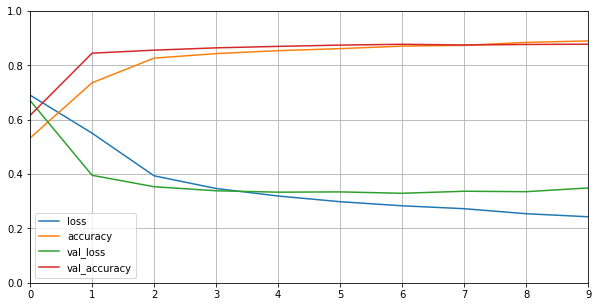

In [15]:
pd.DataFrame(history7.history).plot(figsize=(10, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.gca().set_xlim(0, 9)
plt.show()

Evaluate model with test set and print first ten predictions and labels

In [16]:
X_test_encoded = encode_words(X_test)

In [17]:
model7.evaluate(X_test_encoded, y_test)

2965/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.34897101738727315, 0.8752108]

In [18]:
X_new = X_test_encoded[:10]
y_proba = model7.predict(X_new)
for i in range(len(y_proba)):
    print(str(i+1) + ".\nPrediction: " + str(y_proba[i][0].round(2)) + "\nActual: " + str(y_test[i].numpy()) + "\n")

1.
Prediction: 0.96
Actual: 1

2.
Prediction: 0.01
Actual: 0

3.
Prediction: 0.95
Actual: 0

4.
Prediction: 0.96
Actual: 1

5.
Prediction: 0.95
Actual: 1

6.
Prediction: 0.96
Actual: 1

7.
Prediction: 0.96
Actual: 1

8.
Prediction: 0.97
Actual: 1

9.
Prediction: 0.28
Actual: 1

10.
Prediction: 0.93
Actual: 0



Save model and test saved model by loading and comparing first ten predictions with the ten above

In [19]:
model7.save("saved_models\\" + DATASET + '.h5')

In [20]:
new_model = keras.models.load_model("saved_models\\" + DATASET + '.h5')

In [21]:
X_new = X_test_encoded[:10]
new_y_proba = new_model.predict(X_new)
for i in range(len(new_y_proba)):
    print(str(i+1) + ".\nPrediction: " + str(new_y_proba[i][0].round(2)) + "\nActual: " + str(y_test[i].numpy()) + "\n")

1.
Prediction: 0.96
Actual: 1

2.
Prediction: 0.01
Actual: 0

3.
Prediction: 0.95
Actual: 0

4.
Prediction: 0.96
Actual: 1

5.
Prediction: 0.95
Actual: 1

6.
Prediction: 0.96
Actual: 1

7.
Prediction: 0.96
Actual: 1

8.
Prediction: 0.97
Actual: 1

9.
Prediction: 0.28
Actual: 1

10.
Prediction: 0.93
Actual: 0

